<h1> Bước 1: </h1> Cài đặt thư viện và chương trình

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense
from keras.utils.vis_utils import plot_model
import pickle

<h1> Bước 2:</h1> Sử dụng, khai thác thông tin dữ liệu

In [2]:
data = pd.read_csv('Data.csv', na_values=['null'], index_col='Date', parse_dates=True)

In [3]:
print(f"Số lượng dữ liệu: {data.shape[0]}x{data.shape[1]}")

Số lượng dữ liệu: 3776x6


In [4]:
data.drop(["Adj Close"], axis=1, inplace=True)
data.head() # 5 dòng đầu

,Open,High,Low,Close,Volume
Date,,,,,
2003-12-31,4.045714,4.091429,3.880714,3.906429,16801400
2004-01-02,4.107143,4.127857,3.842143,3.916429,50230600
2004-01-05,3.892857,4.061429,3.875000,3.992857,25207000
2004-01-06,3.946429,4.339286,3.937143,4.257857,52633000
2004-01-07,4.307143,4.470000,4.249286,4.445714,68432000


In [5]:
data.info() # Thông tin của từng cột dữ liệu

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3776 entries, 2003-12-31 to 2018-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3776 non-null   float64
 1   High    3776 non-null   float64
 2   Low     3776 non-null   float64
 3   Close   3776 non-null   float64
 4   Volume  3776 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 177.0 KB


In [6]:
data.describe() # Thông tin từng cột dữ liệu

,Open,High,Low,Close,Volume
count,3776.000000,3776.000000,3776.000000,3776.000000,3.776000e+03
mean,56.653638,57.552998,55.681395,56.643953,1.918587e+07
std,85.461244,86.790599,83.904099,85.372837,2.074758e+07
min,1.300000,1.317143,1.272857,1.290000,1.493800e+06
25%,4.082857,4.156786,3.992857,4.094286,7.792225e+06
50%,15.432143,15.760714,15.046429,15.395000,1.297695e+07
75%,68.606428,69.155716,67.800713,68.397860,2.287355e+07
max,421.380005,423.209991,413.079987,418.970001,3.234140e+08


<h3> Tính tỷ suất lợi nhuận </h3>

In [7]:
Profit_Margin = pd.DataFrame() # DataFrame này có tác dụng dùng để chứa giá trị tỷ suất lợi nhuận cho từng ngày
Profit_Margin['Profit_Margin__Open'] = data['Open'].pct_change()
Profit_Margin['Profit_Margin__High'] = data['High'].pct_change()
Profit_Margin['Profit_Margin__Low'] = data['Low'].pct_change()
Profit_Margin['Profit_Margin__Close'] = data['Close'].pct_change()
Profit_Margin['Profit_Margin__Volume'] = data['Volume'].pct_change()
Profit_Margin = Profit_Margin.dropna()
Profit_Margin.head()

,Profit_Margin__Open,Profit_Margin__High,Profit_Margin__Low,Profit_Margin__Close,Profit_Margin__Volume
Date,,,,,
2004-01-02,0.015184,0.008903,-0.009939,0.002560,1.989668
2004-01-05,-0.052174,-0.016093,0.008552,0.019515,-0.498174
2004-01-06,0.013762,0.068414,0.016037,0.066369,1.088031
2004-01-07,0.091403,0.030123,0.079282,0.044120,0.300173
2004-01-08,0.053897,0.021093,0.009918,-0.002892,-0.456710


<h3>Trực quan hóa dữ liệu</h3>

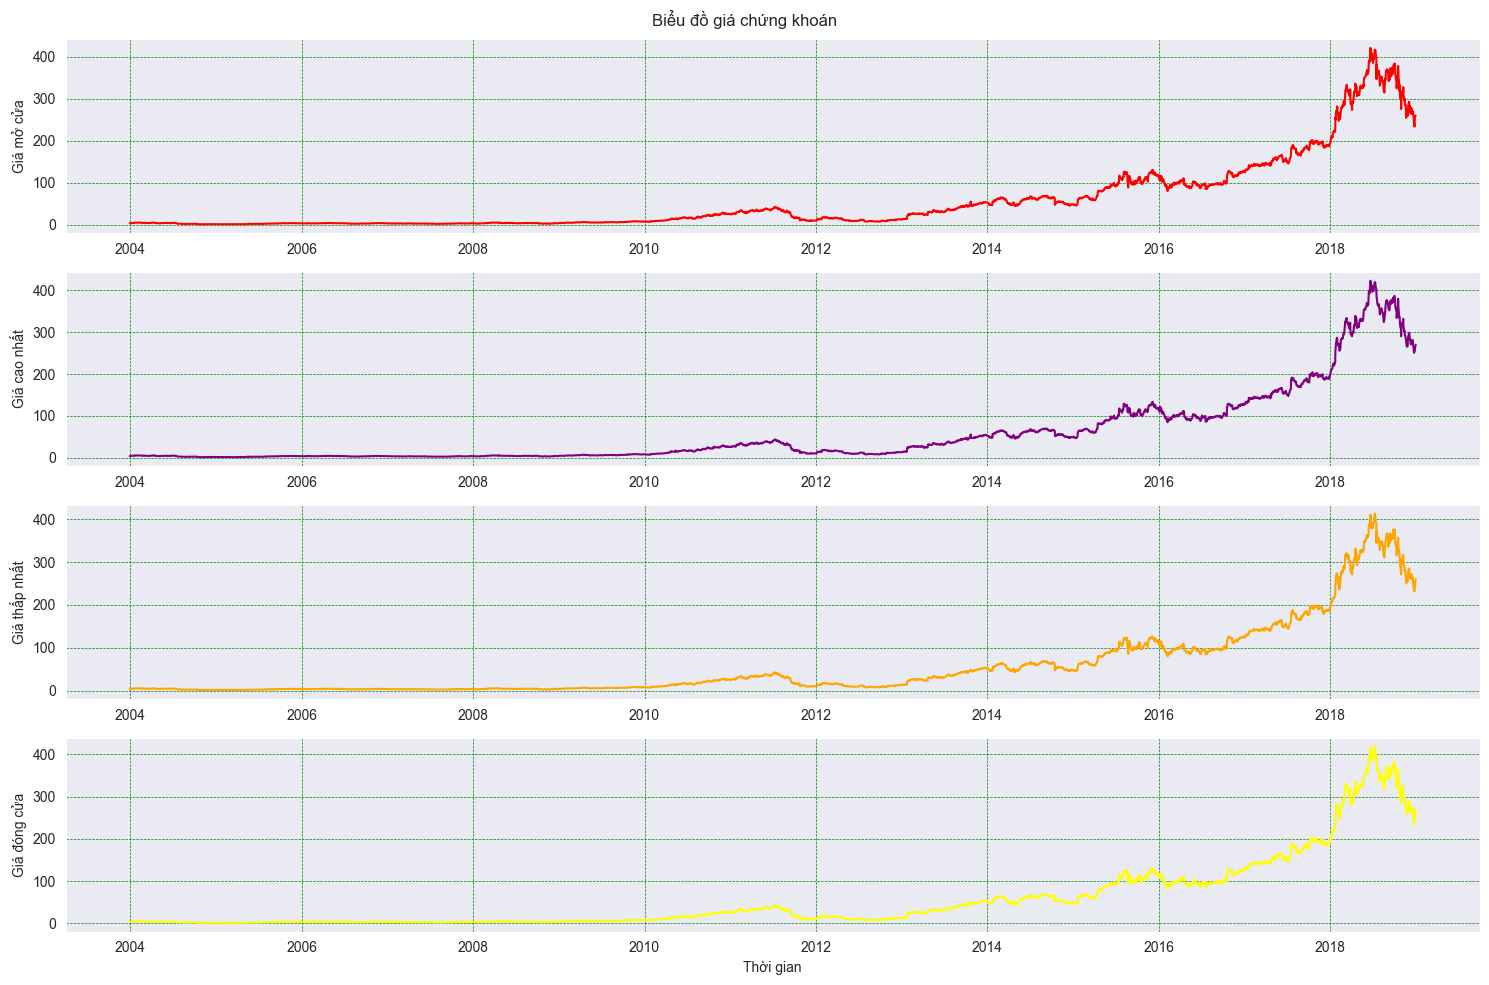

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

# Biểu đồ giá mở cửa
axs[0].plot(data['Open'], color="red")
axs[0].set_ylabel("Giá mở cửa")
axs[0].grid(color='green', linestyle='--', linewidth=0.5)

# Biểu đồ giá cao nhất
axs[1].plot(data['High'], color="purple")
axs[1].set_ylabel("Giá cao nhất")
axs[1].grid(color='green', linestyle='--', linewidth=0.5)

# Biểu đồ giá thấp nhất
axs[2].plot(data['Low'], color="orange")
axs[2].set_ylabel("Giá thấp nhất")
axs[2].grid(color='green', linestyle='--', linewidth=0.5)

# Biểu đồ giá đóng cửa
axs[3].plot(data['Close'], color="yellow")
axs[3].set_ylabel("Giá đóng cửa")
axs[3].grid(color='green', linestyle='--', linewidth=0.5)

# Đặt tiêu đề chung cho biểu đồ
fig.suptitle("Biểu đồ giá chứng khoán")

# Định dạng đồ thị
plt.xlabel("Thời gian")
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

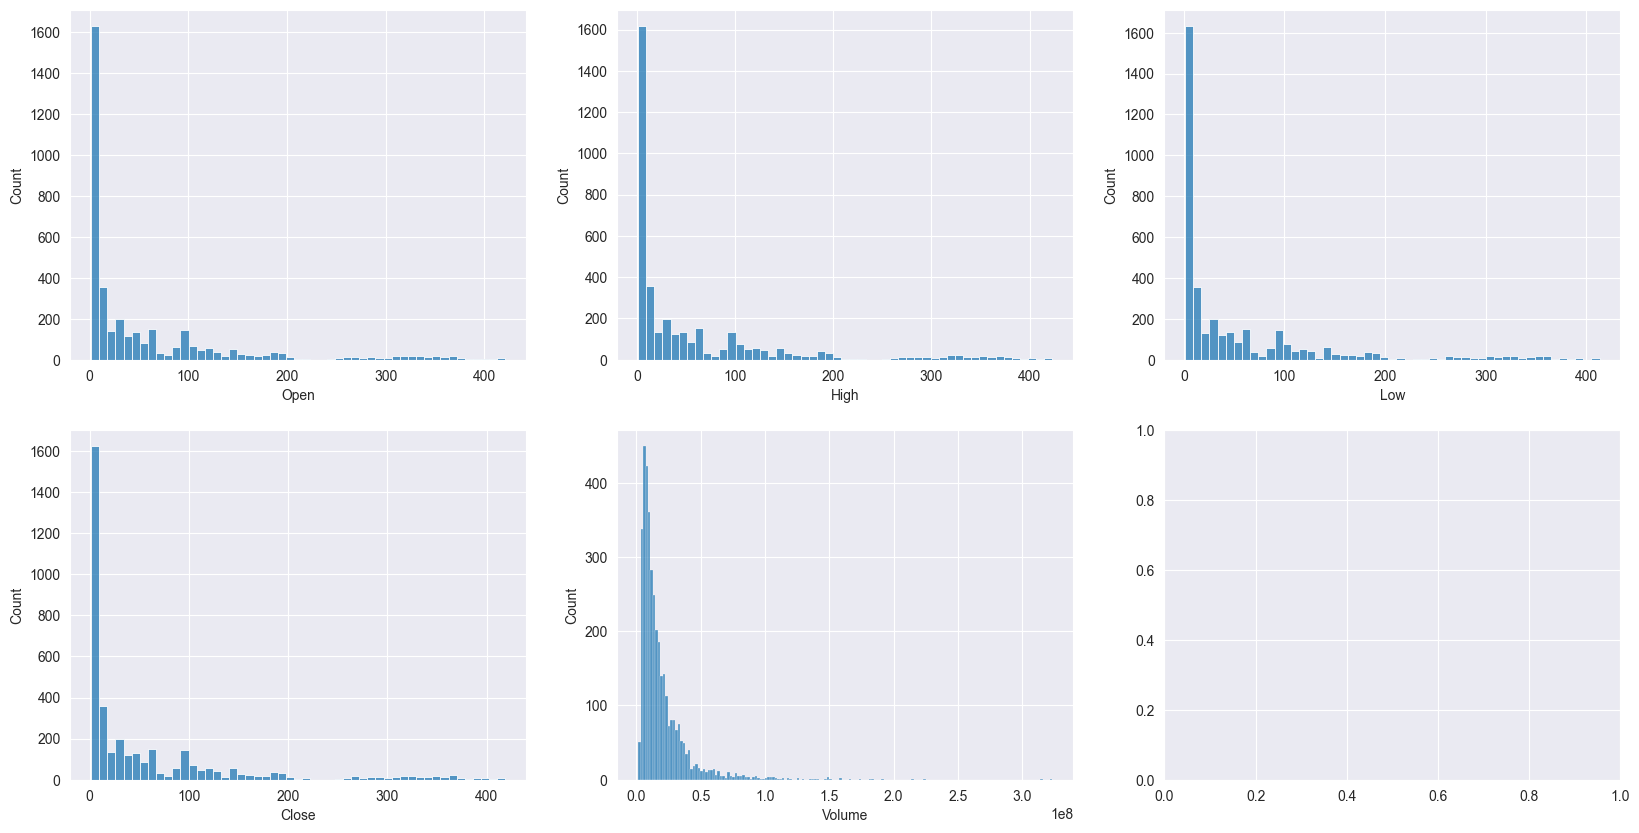

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, col in enumerate(features):
    sb.histplot(data[col], ax=axes[i // 3, i % 3])
plt.show()

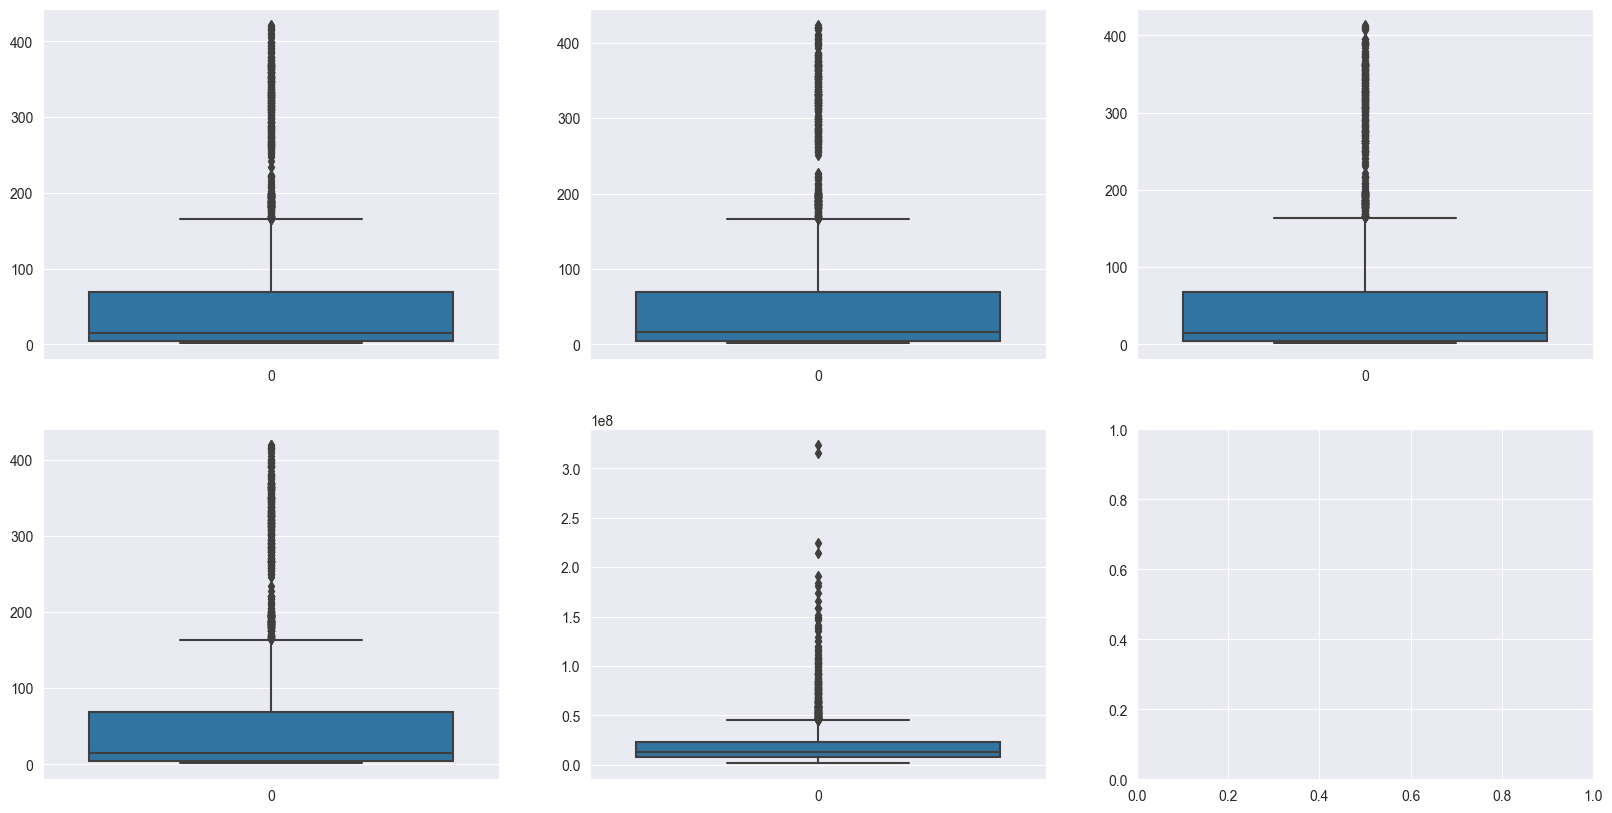

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, col in enumerate(features):
    sb.boxplot(data[col], ax=axes[i // 3, i % 3])
plt.show()

<h1> Bước 3:</h1> Sử dụng dữ liệu để thực hiện huấn luyện cho mô hình

<li>Sử dụng thông tin dữ liệu của giá 'High', 'Low', 'Close' và 'Volume' để dự đoán giá 'Open'</li>

In [11]:
features_Open = ["High", "Low", "Close", "Volume"]
output_var_Open = pd.DataFrame(data["Open"])

scaler_Open = MinMaxScaler(feature_range=(0, 1))
feature_transform_Open = scaler_Open.fit_transform(data[features_Open])
feature_transform_Open = pd.DataFrame(columns=features_Open, data=feature_transform_Open, index=data.index)

In [12]:
# Chia tập dữ liệu thành các tập train và test
timesplit = TimeSeriesSplit(n_splits=10)
for train_index_Open, test_index_Open in timesplit.split(feature_transform_Open):
    X_train_Open, X_test_Open = feature_transform_Open[:len(train_index_Open)], feature_transform_Open[len(train_index_Open): (len(train_index_Open)+len(test_index_Open))]
    y_train_Open, y_test_Open = output_var_Open[1:len(train_index_Open)+1].values.ravel(), output_var_Open[len(train_index_Open)+1: (len(train_index_Open)+len(test_index_Open)+1)].values.ravel()
    X_test_Open = X_test_Open[:-1]

In [13]:
# Chuyển đổi dữ liệu thành dạng phù hợp cho LSTM
trainX_Open = np.array(X_train_Open)
testX_Open = np.array(X_test_Open)
X_train_Open = trainX_Open.reshape(X_train_Open.shape[0], 1, X_train_Open.shape[1])
X_test_Open = testX_Open.reshape(X_test_Open.shape[0], 1, X_test_Open.shape[1])

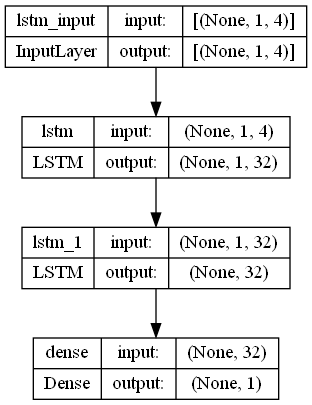

In [14]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(32, input_shape=(X_train_Open.shape[1], X_train_Open.shape[2]), activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
# Huấn luyện mô hình
save_model = 'Model/Model_Open.h5'
plot_model(model, show_shapes=True, show_layer_names=True)
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only=True, mode='auto')
model.fit(X_train_Open, y_train_Open, epochs=100, batch_size=8, verbose=1, callbacks=[best_model])

Epoch 1/100
424/430 [============================>.] - ETA: 0s - loss: 1991.5651
Epoch 1: loss improved from inf to 1974.17712, saving model to Model\Model_Open.h5
430/430 [==============================] - 4s 2ms/step - loss: 1974.1771
Epoch 2/100
405/430 [===========================>..] - ETA: 0s - loss: 179.0140
Epoch 2: loss improved from 1974.17712 to 171.19974, saving model to Model\Model_Open.h5
430/430 [==============================] - 1s 2ms/step - loss: 171.1997
Epoch 3/100
422/430 [============================>.] - ETA: 0s - loss: 21.7101
Epoch 3: loss improved from 171.19974 to 21.54219, saving model to Model\Model_Open.h5
430/430 [==============================] - 1s 2ms/step - loss: 21.5422
Epoch 4/100
407/430 [===========================>..] - ETA: 0s - loss: 6.4237
Epoch 4: loss improved from 21.54219 to 6.32752, saving model to Model\Model_Open.h5
430/430 [==============================] - 1s 2ms/step - loss: 6.3275
Epoch 5/100
402/430 [===========================>..]

In [16]:
with open('Model/scaler_Open.pkl', 'wb') as file:
    pickle.dump(scaler_Open, file)

Kết quả (MSE): 286.7857971191406
11/11 [==============================] - 0s 1ms/step
R₂:  0.9446487431044338
MAE:  12.787443030410499
MAPE:  0.038906938928441645 %


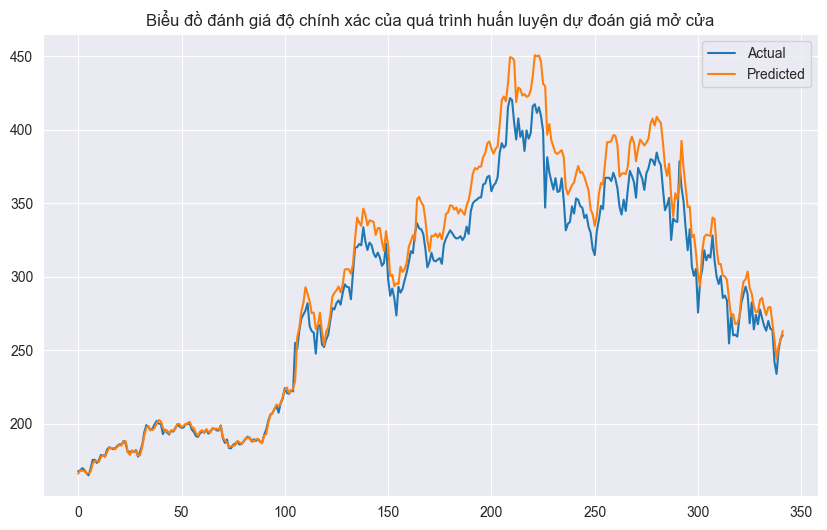

In [17]:
# Đánh giá độ chính xác trên tập kiểm tra
loss = model.evaluate(X_test_Open, y_test_Open, verbose=0)
print("Kết quả (MSE):", loss) # Lỗi bình phương trung bình trên bộ TEST
y_pred_Open = model.predict(X_test_Open)
r2 = r2_score(y_test_Open, y_pred_Open)
mae = mean_absolute_error(y_test_Open, y_pred_Open)
mape = mean_absolute_percentage_error(y_test_Open, y_pred_Open)

print("R₂: ", r2) # Độ chính xác của tập Train (R2 Score)
print("MAE: ", mae) # Sai số tuyệt đối trung bình của tập Train (Mean Absolute Error)
print("MAPE: ", mape , "%") # Phần trăm sai số tuyệt đối trung bình của tập Train (Mean Absolute Percentage Error)

# Vẽ biểu đồ đánh giá độ chính xác
plt.figure(figsize=(10, 6))
plt.plot(y_test_Open, label='Actual')
plt.plot(y_pred_Open, label='Predicted')
plt.title('Biểu đồ đánh giá độ chính xác của quá trình huấn luyện dự đoán giá mở cửa')
plt.legend()
plt.show()

<li>Sử dụng thông tin dữ liệu của giá 'Open', 'Low', 'Close' và 'Volume' để dự đoán giá 'High'</li>

In [18]:
features_High = ["Open", "Low", "Close", "Volume"]
output_var_High = pd.DataFrame(data["High"])

scaler_High = MinMaxScaler(feature_range=(0, 1))
feature_transform_High = scaler_High.fit_transform(data[features_High])
feature_transform_High = pd.DataFrame(columns=features_High, data=feature_transform_High, index=data.index)

In [19]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index_High, test_index_High in timesplit.split(feature_transform_High):
    X_train_High, X_test_High = feature_transform_High[:len(train_index_High)], feature_transform_High[len(train_index_High): (len(train_index_High)+len(test_index_High))]
    y_train_High, y_test_High = output_var_High[1:len(train_index_High)+1].values.ravel(), output_var_High[len(train_index_High)+1: (len(train_index_High)+len(test_index_High)+1)].values.ravel()
    X_test_High = X_test_High[:-1]

In [20]:
trainX_High = np.array(X_train_High)
testX_High = np.array(X_test_High)
X_train_High = trainX_High.reshape(X_train_High.shape[0], 1, X_train_High.shape[1])
X_test_High = testX_High.reshape(X_test_High.shape[0], 1, X_test_High.shape[1])

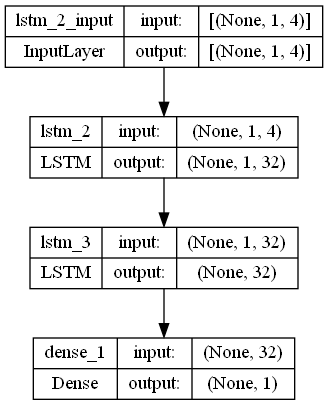

In [21]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train_High.shape[1], X_train_High.shape[2]), activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

In [22]:
save_model = 'Model/Model_High.h5'
plot_model(model, show_shapes=True, show_layer_names=True)
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only=True, mode='auto')
model.fit(X_train_High, y_train_High, epochs=100, batch_size=8, verbose=1, callbacks=[best_model])

Epoch 1/100
419/430 [============================>.] - ETA: 0s - loss: 2055.6021
Epoch 1: loss improved from inf to 2019.95203, saving model to Model\Model_High.h5
430/430 [==============================] - 3s 2ms/step - loss: 2019.9520
Epoch 2/100
414/430 [===========================>..] - ETA: 0s - loss: 219.0337
Epoch 2: loss improved from 2019.95203 to 213.69807, saving model to Model\Model_High.h5
430/430 [==============================] - 1s 2ms/step - loss: 213.6981
Epoch 3/100
426/430 [============================>.] - ETA: 0s - loss: 45.5401
Epoch 3: loss improved from 213.69807 to 45.42267, saving model to Model\Model_High.h5
430/430 [==============================] - 1s 2ms/step - loss: 45.4227
Epoch 4/100
399/430 [==========================>...] - ETA: 0s - loss: 24.7347
Epoch 4: loss improved from 45.42267 to 24.18331, saving model to Model\Model_High.h5
430/430 [==============================] - 1s 2ms/step - loss: 24.1833
Epoch 5/100
420/430 [============================

In [23]:
with open('Model/scaler_High.pkl', 'wb') as file:
    pickle.dump(scaler_High, file)

Kết quả (MSE): 332.60125732421875
11/11 [==============================] - 0s 952us/step
R₂:  0.9378313819843034
MAE:  13.867480369694583
MAPE:  0.041942958426475864 %


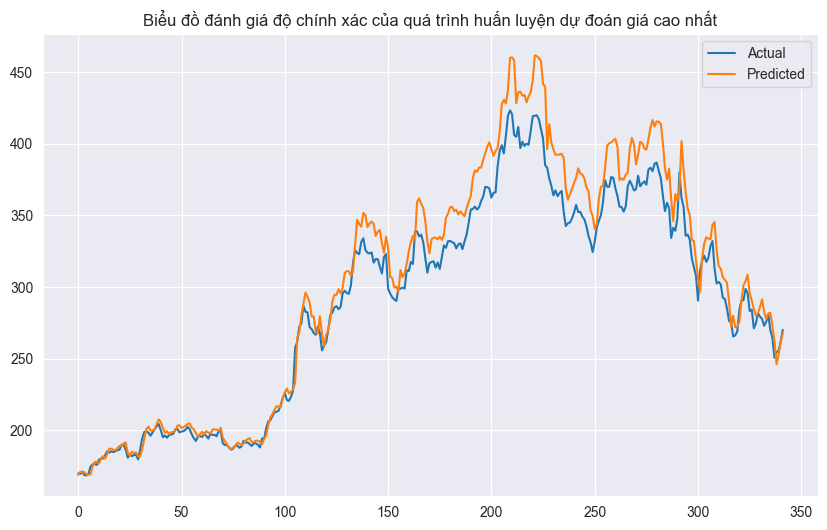

In [24]:
loss = model.evaluate(X_test_High, y_test_High, verbose=0)
print("Kết quả (MSE):", loss)
y_pred_High = model.predict(X_test_High)
r2 = r2_score(y_test_High, y_pred_High)
mae = mean_absolute_error(y_test_High, y_pred_High)
mape = mean_absolute_percentage_error(y_test_High, y_pred_High)
print("R₂: ", r2)
print("MAE: ", mae)
print("MAPE: ", mape , "%")
plt.figure(figsize=(10, 6))
plt.plot(y_test_High, label='Actual')
plt.plot(y_pred_High, label='Predicted')
plt.title('Biểu đồ đánh giá độ chính xác của quá trình huấn luyện dự đoán giá cao nhất')
plt.legend()
plt.show()

<li>Sử dụng thông tin dữ liệu của giá 'Open', 'High', 'Close' và 'Volume' để dự đoán giá 'Low'</li>

In [25]:
features_Low = ["Open", "High", "Close", "Volume"]
output_var_Low = pd.DataFrame(data["Low"])

scaler_Low = MinMaxScaler(feature_range=(0, 1))
feature_transform_Low = scaler_Low.fit_transform(data[features_Low])
feature_transform_Low = pd.DataFrame(columns=features_Low, data=feature_transform_Low, index=data.index)

In [26]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index_Low, test_index_Low in timesplit.split(feature_transform_Low):
    X_train_Low, X_test_Low = feature_transform_Low[:len(train_index_Low)], feature_transform_Low[len(train_index_Low): (len(train_index_Low)+len(test_index_Low))]
    y_train_Low, y_test_Low = output_var_Low[1:len(train_index_Low)+1].values.ravel(), output_var_Low[len(train_index_Low)+1: (len(train_index_Low)+len(test_index_Low)+1)].values.ravel()
    X_test_Low = X_test_Low[:-1]

In [27]:
trainX_Low = np.array(X_train_Low)
testX_Low = np.array(X_test_Low)
X_train_Low = trainX_Low.reshape(X_train_Low.shape[0], 1, X_train_Low.shape[1])
X_test_Low = testX_Low.reshape(X_test_Low.shape[0], 1, X_test_Low.shape[1])

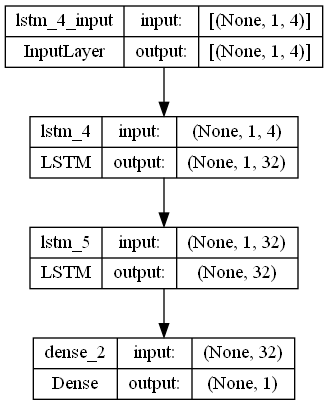

In [28]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train_Low.shape[1], X_train_Low.shape[2]), activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
save_model = 'Model/Model_Low.h5'
plot_model(model, show_shapes=True, show_layer_names=True)
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only=True, mode='auto')
model.fit(X_train_Low, y_train_Low, epochs=100, batch_size=8, verbose=1, callbacks=[best_model])

Epoch 1/100
411/430 [===========================>..] - ETA: 0s - loss: 2031.2129
Epoch 1: loss improved from inf to 1975.42029, saving model to Model\Model_Low.h5
430/430 [==============================] - 3s 2ms/step - loss: 1975.4203
Epoch 2/100
427/430 [============================>.] - ETA: 0s - loss: 178.4060
Epoch 2: loss improved from 1975.42029 to 177.73045, saving model to Model\Model_Low.h5
430/430 [==============================] - 1s 2ms/step - loss: 177.7305
Epoch 3/100
420/430 [============================>.] - ETA: 0s - loss: 15.7666
Epoch 3: loss improved from 177.73045 to 15.62404, saving model to Model\Model_Low.h5
430/430 [==============================] - 1s 3ms/step - loss: 15.6240
Epoch 4/100
421/430 [============================>.] - ETA: 0s - loss: 5.9262
Epoch 4: loss improved from 15.62404 to 5.92627, saving model to Model\Model_Low.h5
430/430 [==============================] - 1s 2ms/step - loss: 5.9263
Epoch 5/100
408/430 [===========================>..] - E

In [30]:
with open('Model/scaler_Low.pkl', 'wb') as file:
    pickle.dump(scaler_Low, file)

Kết quả (MSE): 413.1294250488281
11/11 [==============================] - 0s 814us/step
R₂:  0.9161592922460915
MAE:  15.651664485520033
MAPE:  0.0498908893763721 %


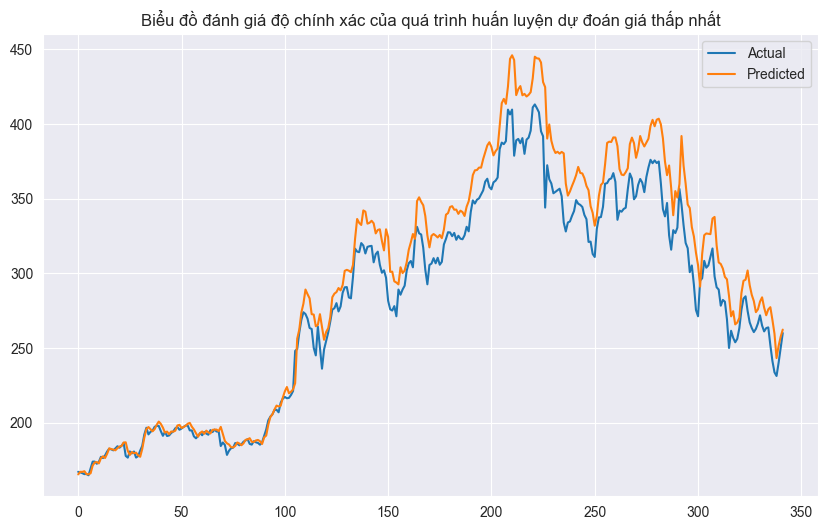

In [31]:
loss = model.evaluate(X_test_Low, y_test_Low, verbose=0)
print("Kết quả (MSE):", loss)
y_pred_Low = model.predict(X_test_Low)
r2 = r2_score(y_test_Low, y_pred_Low)
mae = mean_absolute_error(y_test_Low, y_pred_Low)
mape = mean_absolute_percentage_error(y_test_Low, y_pred_Low)
print("R₂: ", r2)
print("MAE: ", mae)
print("MAPE: ", mape , "%")
plt.figure(figsize=(10, 6))
plt.plot(y_test_Low, label='Actual')
plt.plot(y_pred_Low, label='Predicted')
plt.title('Biểu đồ đánh giá độ chính xác của quá trình huấn luyện dự đoán giá thấp nhất')
plt.legend()
plt.show()

<li>Sử dụng thông tin dữ liệu của giá 'Open', 'High', 'Low' và 'Volume' để dự đoán giá 'Close'</li>

In [32]:
features_Close = ["Open", "High", "Low", "Volume"]
output_var_Close = pd.DataFrame(data["Close"])

scaler_Close = MinMaxScaler(feature_range=(0, 1))
feature_transform_Close = scaler_Close.fit_transform(data[features_Close])
feature_transform_Close = pd.DataFrame(columns=features_Close, data=feature_transform_Close, index=data.index)

In [33]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index_Close, test_index_Close in timesplit.split(feature_transform_Close):
    X_train_Close, X_test_Close = feature_transform_Close[:len(train_index_Close)], feature_transform_Close[len(train_index_Close): (len(train_index_Close)+len(test_index_Close))]
    y_train_Close, y_test_Close = output_var_Close[1:len(train_index_Close)+1].values.ravel(), output_var_Close[len(train_index_Close)+1: (len(train_index_Close)+len(test_index_Close)+1)].values.ravel()
    X_test_Close = X_test_Close[:-1]

In [34]:
trainX_Close = np.array(X_train_Close)
testX_Close = np.array(X_test_Close)
X_train_Close = trainX_Close.reshape(X_train_Close.shape[0], 1, X_train_Close.shape[1])
X_test_Close = testX_Close.reshape(X_test_Close.shape[0], 1, X_test_Close.shape[1])

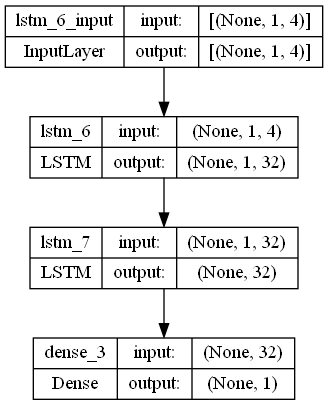

In [35]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train_Close.shape[1], X_train_Close.shape[2]), activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

In [36]:
save_model = 'Model/Model_Close.h5'
plot_model(model, show_shapes=True, show_layer_names=True)
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only=True, mode='auto')
model.fit(X_train_Close, y_train_Close, epochs=100, batch_size=8, verbose=1, callbacks=[best_model])

Epoch 1/100
397/430 [==========================>...] - ETA: 0s - loss: 2194.8584
Epoch 1: loss improved from inf to 2079.15674, saving model to Model\Model_Close.h5
430/430 [==============================] - 2s 1ms/step - loss: 2079.1567
Epoch 2/100
425/430 [============================>.] - ETA: 0s - loss: 154.2818
Epoch 2: loss improved from 2079.15674 to 152.88708, saving model to Model\Model_Close.h5
430/430 [==============================] - 1s 1ms/step - loss: 152.8871
Epoch 3/100
409/430 [===========================>..] - ETA: 0s - loss: 5.7478
Epoch 3: loss improved from 152.88708 to 5.75781, saving model to Model\Model_Close.h5
430/430 [==============================] - 1s 1ms/step - loss: 5.7578
Epoch 4/100
409/430 [===========================>..] - ETA: 0s - loss: 4.0115
Epoch 4: loss improved from 5.75781 to 4.05942, saving model to Model\Model_Close.h5
430/430 [==============================] - 1s 1ms/step - loss: 4.0594
Epoch 5/100
417/430 [============================>.]

In [37]:
with open('Model/scaler_Close.pkl', 'wb') as file:
    pickle.dump(scaler_Close, file)

Kết quả (MSE): 265.5157775878906
11/11 [==============================] - 0s 991us/step
R₂:  0.9482217438586836
MAE:  12.114392341925372
MAPE:  0.03882169356559873 %


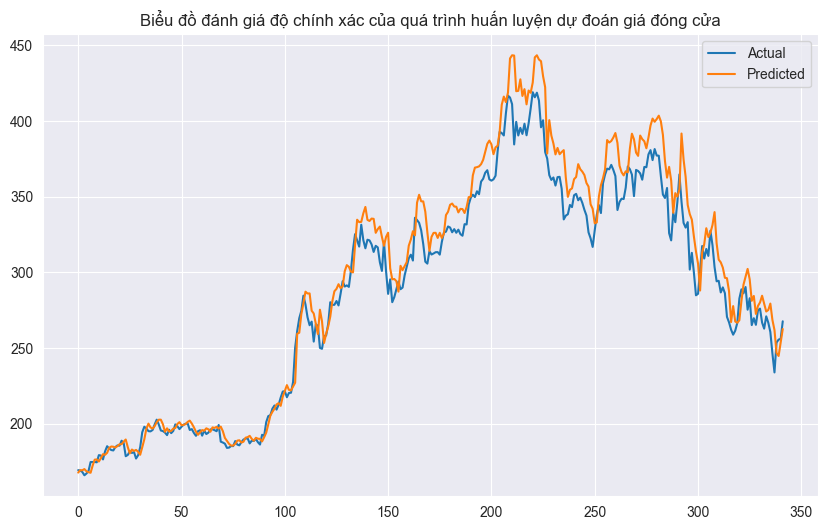

In [38]:
loss = model.evaluate(X_test_Close, y_test_Close, verbose=0)
print("Kết quả (MSE):", loss)
y_pred_Close = model.predict(X_test_Close)
r2 = r2_score(y_test_Close, y_pred_Close)
mae = mean_absolute_error(y_test_Close, y_pred_Close)
mape = mean_absolute_percentage_error(y_test_Close, y_pred_Close)
print("R₂: ", r2)
print("MAE: ", mae)
print("MAPE: ", mape , "%")
plt.figure(figsize=(10, 6))
plt.plot(y_test_Close, label='Actual')
plt.plot(y_pred_Close, label='Predicted')
plt.title('Biểu đồ đánh giá độ chính xác của quá trình huấn luyện dự đoán giá đóng cửa')
plt.legend()
plt.show()

<h1> Bước 4:</h1> Kiểm thử kết quả của quá huấn luyện

In [39]:
features_Open_S = ["High", "Low", "Close", "Volume"]
loaded_model_Open = load_model('Model/Model_Open.h5')
with open('Model/scaler_Open.pkl', 'rb') as file:
    scaler_Open_S = pickle.load(file)
high_value = float(input("Nhập giá cao nhất: "))
low_value = float(input("Nhập giá thấp nhất: "))
close_value = float(input("Nhập giá đóng cửa: "))
volume_value = float(input("Nhập khối lượng giao dịch: "))
new_features_Open = scaler_Open_S.transform([[high_value, low_value, close_value, volume_value]])
new_features_Open = pd.DataFrame(columns=features_Open_S, data=new_features_Open)
new_data_Open = np.array(new_features_Open)
new_data_Open = new_data_Open.reshape(new_data_Open.shape[0], 1, new_data_Open.shape[1])
predicted_adj_Open = loaded_model_Open.predict(new_data_Open)
print("Kết quả (dự đoán) giá mở cửa: ", predicted_adj_Open)

D:\Tu_Hoc_Lap_Trinh\Python\Major_Assignment\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 207ms/step
Kết quả (dự đoán) giá mở cửa:  [[207.2461]]


In [40]:
features_High_S = ["Open", "Low", "Close", "Volume"]
loaded_model_High = load_model('Model/Model_High.h5')
with open('Model/scaler_High.pkl', 'rb') as file:
    scaler_High_S = pickle.load(file)
open_value = float(input("Nhập giá mở cửa: "))
low_value = float(input("Nhập giá thấp nhất: "))
close_value = float(input("Nhập giá đóng cửa: "))
volume_value = float(input("Nhập khối lượng giao dịch: "))
new_features_High = scaler_High_S.transform([[open_value, low_value, close_value, volume_value]])
new_features_High = pd.DataFrame(columns=features_High_S, data=new_features_High)
new_data_High = np.array(new_features_High)
new_data_High = new_data_High.reshape(new_data_High.shape[0], 1, new_data_High.shape[1])
predicted_adj_High = loaded_model_High.predict(new_data_High)
print("Kết quả (dự đoán) giá cao nhất: ", predicted_adj_High)

D:\Tu_Hoc_Lap_Trinh\Python\Major_Assignment\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 194ms/step
Kết quả (dự đoán) giá cao nhất:  [[216.54784]]


In [41]:
features_Low_S = ["Open", "High", "Close", "Volume"]
loaded_model_Low = load_model('Model/Model_Low.h5')
with open('Model/scaler_Low.pkl', 'rb') as file:
    scaler_Low_S = pickle.load(file)
open_value = float(input("Hãy nhập giá mở cửa: "))
high_value = float(input("Hãy nhập giá cao nhất: "))
close_value = float(input("Hãy nhập giá đóng cửa: "))
volume_value = float(input("Hãy nhập khối lượng giao dịch: "))
new_features_Low = scaler_Low_S.transform([[open_value, high_value, close_value, volume_value]])
new_features_Low = pd.DataFrame(columns=features_Low_S, data=new_features_Low)
new_data_Low = np.array(new_features_Low)
new_data_Low = new_data_Low.reshape(new_data_Low.shape[0], 1, new_data_Low.shape[1])
predicted_adj_Low = loaded_model_Low.predict(new_data_Low)
print("Kết quả giá thấp nhất (Dự đoán) cho ngày mai:", predicted_adj_Low)

D:\Tu_Hoc_Lap_Trinh\Python\Major_Assignment\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 175ms/step
Kết quả giá thấp nhất (Dự đoán) cho ngày mai: [[212.44211]]


In [42]:
loaded_model_Close = load_model('Model/Model_Close.h5')
features_Close_S = ["Open", "High", "Low", "Volume"]
with open('Model/scaler_Close.pkl', 'rb') as file:
    scaler_Close_S = pickle.load(file)
open_value = float(input("Hãy nhập giá mở cửa: "))
high_value = float(input("Hãy nhập giá cao nhất: "))
low_value = float(input("Hãy nhập giá thấp nhất: "))
volume_value = float(input("Hãy nhập khối lượng giao dịch: "))
new_features_Close = scaler_Close_S.transform([[open_value, high_value, low_value, volume_value]])
new_features_Close = pd.DataFrame(columns=features_Close_S, data=new_features_Close)
new_data_Close = np.array(new_features_Close)
new_data_Close = new_data_Close.reshape(new_data_Close.shape[0], 1, new_data_Close.shape[1])
predicted_adj_close = loaded_model_Close.predict(new_data_Close)
print("Kết quả giá đóng cửa (Dự đoán) cho ngày mai:", predicted_adj_close)

D:\Tu_Hoc_Lap_Trinh\Python\Major_Assignment\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 189ms/step
Kết quả giá đóng cửa (Dự đoán) cho ngày mai: [[221.80846]]
